In [1]:
import os
import rich
import scipy

import numpy as np
import pandas

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
joint_list = [
    "Nose", "Head", "Left Ear",
    "Right Ear", "Trunk", "Tail Base",
    "Tail_tip", "t0", "t1", "t2",
    "neck", "Left Hpaw", "Right Hpaw",
    "Left Fpaw", "Right Fpaw"
]

In [3]:
data_path = "/mnt/cup/people/tt1131/projects/rotation_project_spring/tracks_evaluation/"
condition_list = ["sham_gdx", "testosterone", "gdx", "intact"]
sample_dict = np.load(
    os.path.join(data_path, f"{condition_list[-1]}_track_dict_abrv.npy"),
    allow_pickle=True,
).item()

In [4]:
track_occupancy_list = []
locations_list = []
joint_scores_list = []

for dict_key in sample_dict.keys():
    t_o = sample_dict[dict_key][3]
    loc = sample_dict[dict_key][4]
    js = sample_dict[dict_key][5]
    track_occupancy_list.append(t_o)
    joint_scores_list.append(js)
    locations_list.append(loc)

In [5]:
from einops import rearrange

nan_portion = np.zeros(len(locations_list))

for idx, track in enumerate(locations_list):
    random_js = rearrange(track[..., 0], "t j d -> t (j d)")
    nan_values = np.isnan(random_js).sum()
    nan_count = (nan_values / random_js.size) * 100
    nan_portion[idx] = nan_count

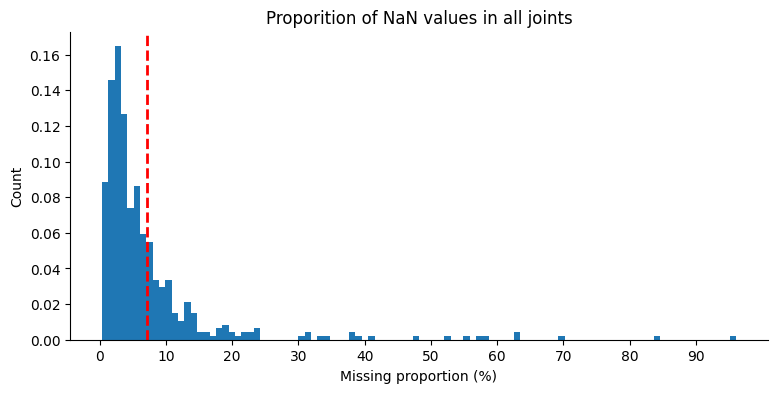

In [6]:
fig, axs = plt.subplots(figsize = (9, 4))
_ = axs.hist(nan_portion, bins = 100, density = True)
axs.axvline(np.mean(nan_portion), color = "r", ls = "--", lw = 2)
axs.set_xticks(np.arange(0, 100, 10))

axs.set_title("Proporition of NaN values in all joints")
axs.set_ylabel("Count")
axs.set_xlabel("Missing proportion (%)")

sns.despine()

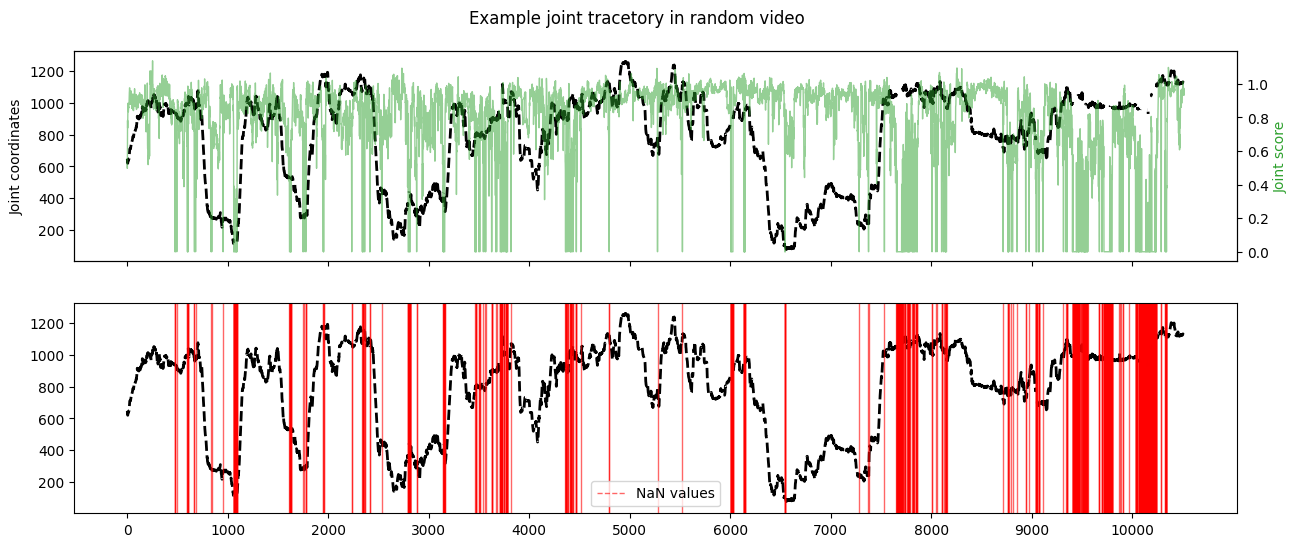

In [7]:
around_avg_error_examples = np.where((nan_portion > 7) & (nan_portion < 9))[0]
random_joints = rearrange(locations_list[around_avg_error_examples[0]][..., 0], "t j d -> t (j d)")[:, 0]
random_js = joint_scores_list[around_avg_error_examples[0]][:, 0, 0]

nan_indices = np.where(np.isnan(random_joints))[0]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex = True)
ax1.plot(random_joints, ls="--", lw=2, c="k")
ax1.set_ylabel("Joint coordinates", color="k")
ax2.plot(random_joints, ls="--", lw=2, c="k")

ax2.plot([], c="r", lw=1, alpha=.6, ls="--", label="NaN values")
ax2.legend()

ax3 = ax1.twinx()
ax3.plot(np.nan_to_num(random_js), c="tab:green", lw=1, alpha = .5)
ax3.set_ylabel("Joint score", color="tab:green")

plt.suptitle("Example joint tracetory in random video", y = .95)

for i in nan_indices:
    ax2.axvline(i, c="r", lw=1, alpha = .6)
_ = ax1.set_xticks(np.arange(0, random_joints.shape[0], 1000))

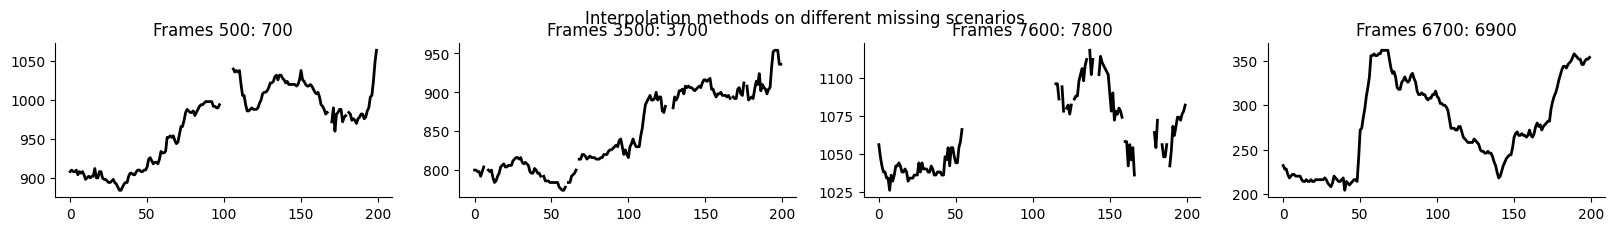

In [92]:
fig, axs = plt.subplots(1, 4, figsize = (20, 2), sharex = True)
frame_duration = [(500, 700), (3500, 3700), (7600, 7800), (6700, 6900)]

## Original data, with those 0 as nans
for dur, ax in zip(frame_duration, axs.flatten()[: 4]):
    ax.plot(random_joints[dur[0]: dur[1]], lw = 2, c = "k")
    ax.set_title(f"Frames {dur[0]}: {dur[1]}")

plt.suptitle("Interpolation methods on different missing scenarios", y = 1.05)

sns.despine()

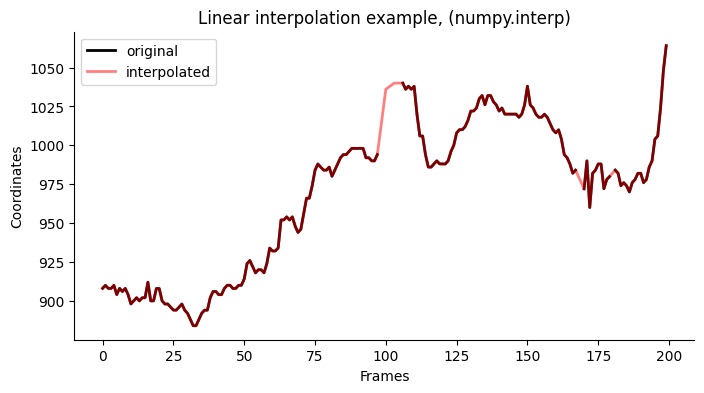

In [93]:
import copy

## numpy linear interpolation
y = copy.deepcopy(random_joints[500: 700])

nan_indices = np.argwhere(np.isnan(y)).flatten()
data_indices = np.argwhere(~np.isnan(y)).flatten()
data_points = y[data_indices]

y[nan_indices]= np.interp(nan_indices, data_indices, data_points)

fig, axs = plt.subplots(figsize = (8, 4))
axs.plot(random_joints[500: 700], c = "k", label = "original", lw = 2)
axs.plot(y, c = "r", label = "interpolated", alpha = .5, lw = 2)
axs.set_title("Linear interpolation example, (numpy.interp)")
axs.set_xlabel("Frames")
axs.set_ylabel("Coordinates")
axs.legend()

sns.despine()

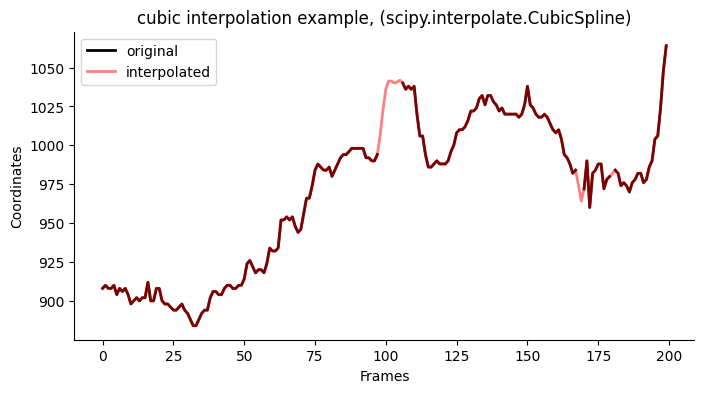

In [94]:
## Interpolate nan values using scipy.interpolate.CubicSpline
import scipy.interpolate as interpolate
y = copy.deepcopy(random_joints[500: 700])
nan_indices = np.argwhere(np.isnan(y)).flatten()
data_indices = np.argwhere(~np.isnan(y)).flatten()
data_points = y[data_indices]

cubic_spline = interpolate.CubicSpline(data_indices, data_points)
y[nan_indices]= cubic_spline(nan_indices)

fig, axs = plt.subplots(figsize = (8, 4))
axs.plot(random_joints[500: 700], c = "k", label = "original", lw = 2)
axs.plot(y, c = "r", label = "interpolated", alpha = .5, lw = 2)
axs.set_title("cubic interpolation example, (scipy.interpolate.CubicSpline)")
axs.set_xlabel("Frames")
axs.set_ylabel("Coordinates")
axs.legend()

sns.despine()

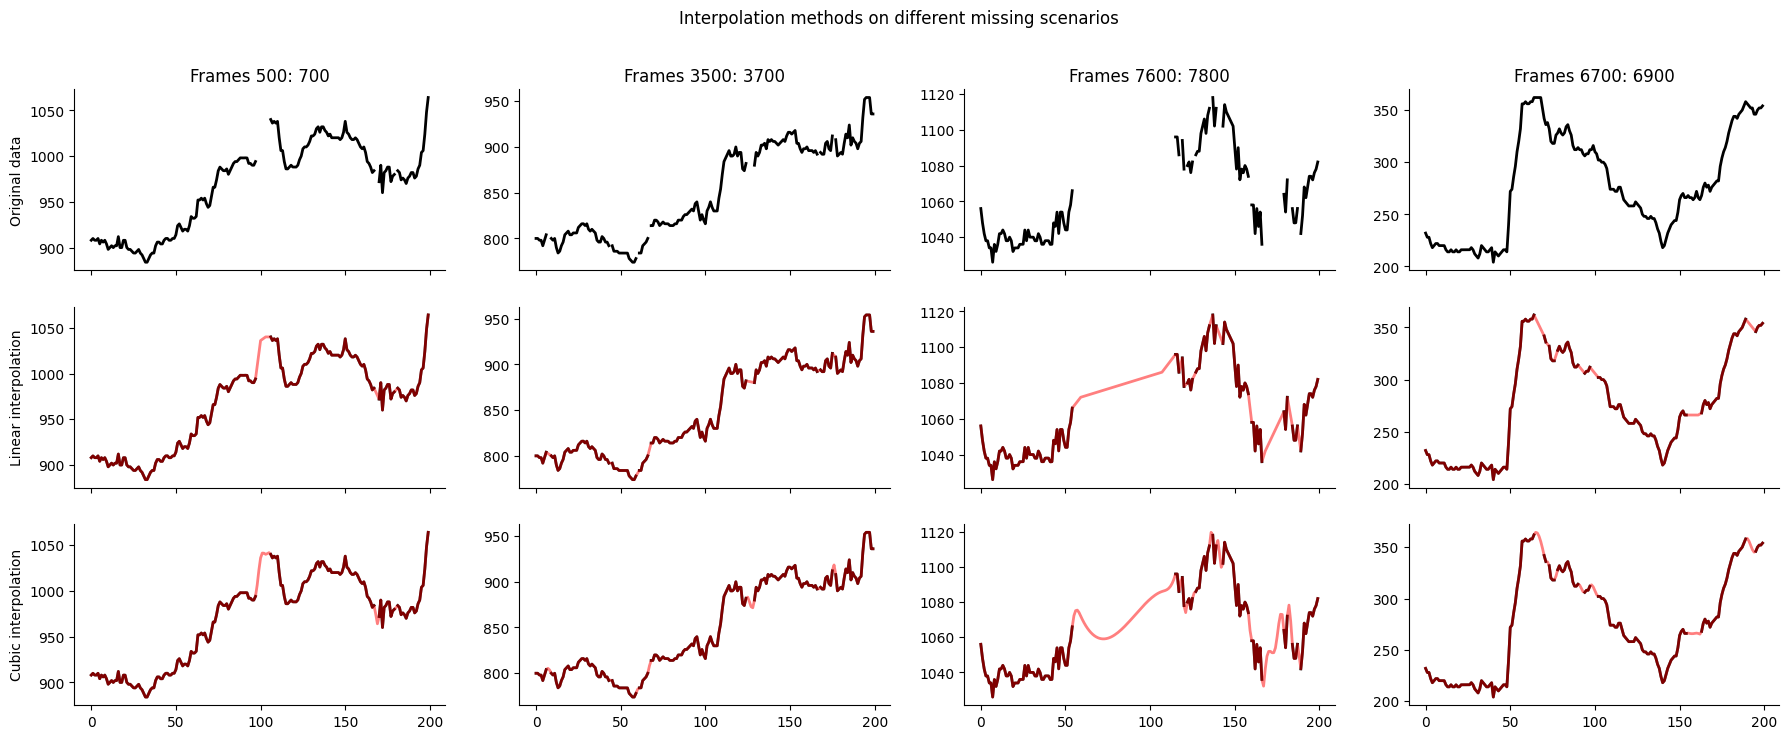

In [99]:
fig, axs = plt.subplots(3, 4, figsize = (22, 8), sharex = True)

frame_duration = [(500, 700), (3500, 3700), (7600, 7800), (6700, 6900)]
test_nan_indices = np.array([65, 66, 67, 68, 69,
                             72, 77, 91, 92, 93,
                             93, 98, 99, 100, 101,
                             155, 157, 158, 160, 162,
                             190, 191, 192, 193, 194])

# Original
for dur, ax in zip(frame_duration, axs.flatten()[:4]):
    ax.plot(random_joints[dur[0]: dur[1]], lw = 2, c = "k")
    ax.set_title(f"Frames {dur[0]}: {dur[1]}")

## np.interp
for idx, (dur, ax) in enumerate(zip(frame_duration, axs.flatten()[4: 8])):
    y = copy.deepcopy(random_joints[dur[0]: dur[1]])
    if idx == 3:
        nan_indices = test_nan_indices
        y[nan_indices] = np.nan
    else:
        nan_indices = np.argwhere(np.isnan(y)).flatten()
        
    data_indices = np.argwhere(~np.isnan(y)).flatten()
    data_points = y[data_indices]

    y[nan_indices]= np.interp(nan_indices, data_indices, data_points)
    if idx == 3:
        y1 = copy.deepcopy(random_joints[dur[0]: dur[1]])
        y1[nan_indices] = np.nan
        ax.plot(y1, c = "k", label = "original", lw = 2)
    else:
        ax.plot(random_joints[dur[0]: dur[1]], c = "k", label = "original", lw = 2)
        
    ax.plot(y, c = "r", label = "interpolated", alpha = .5, lw = 2)

## scipy.interpolate.CubicSpline
for idx, (dur, ax) in enumerate(zip(frame_duration, axs.flatten()[8:])):
    y = copy.deepcopy(random_joints[dur[0]: dur[1]])
    if idx == 3:
        nan_indices = test_nan_indices
        y[nan_indices] = np.nan
    else:
        nan_indices = np.argwhere(np.isnan(y)).flatten()
        
    data_indices = np.argwhere(~np.isnan(y)).flatten()
    data_points = y[data_indices]

    cubic_spline = interpolate.CubicSpline(data_indices, data_points)
    y[nan_indices]= cubic_spline(nan_indices)

    if idx == 3:
        y1 = copy.deepcopy(random_joints[dur[0]: dur[1]])
        y1[nan_indices] = np.nan
        ax.plot(y1, c = "k", label = "original", lw = 2)
    else:
        ax.plot(random_joints[dur[0]: dur[1]], c = "k", label = "original", lw = 2)
        
    ax.plot(y, c = "r", label = "interpolated", alpha = .5, lw = 2)
    

axs[0, 0].set_ylabel("Original data")
axs[1, 0].set_ylabel("Linear interpolation")
axs[2, 0].set_ylabel("Cubic interpolation")

plt.suptitle("Interpolation methods on different missing scenarios", y = .98)
sns.despine()

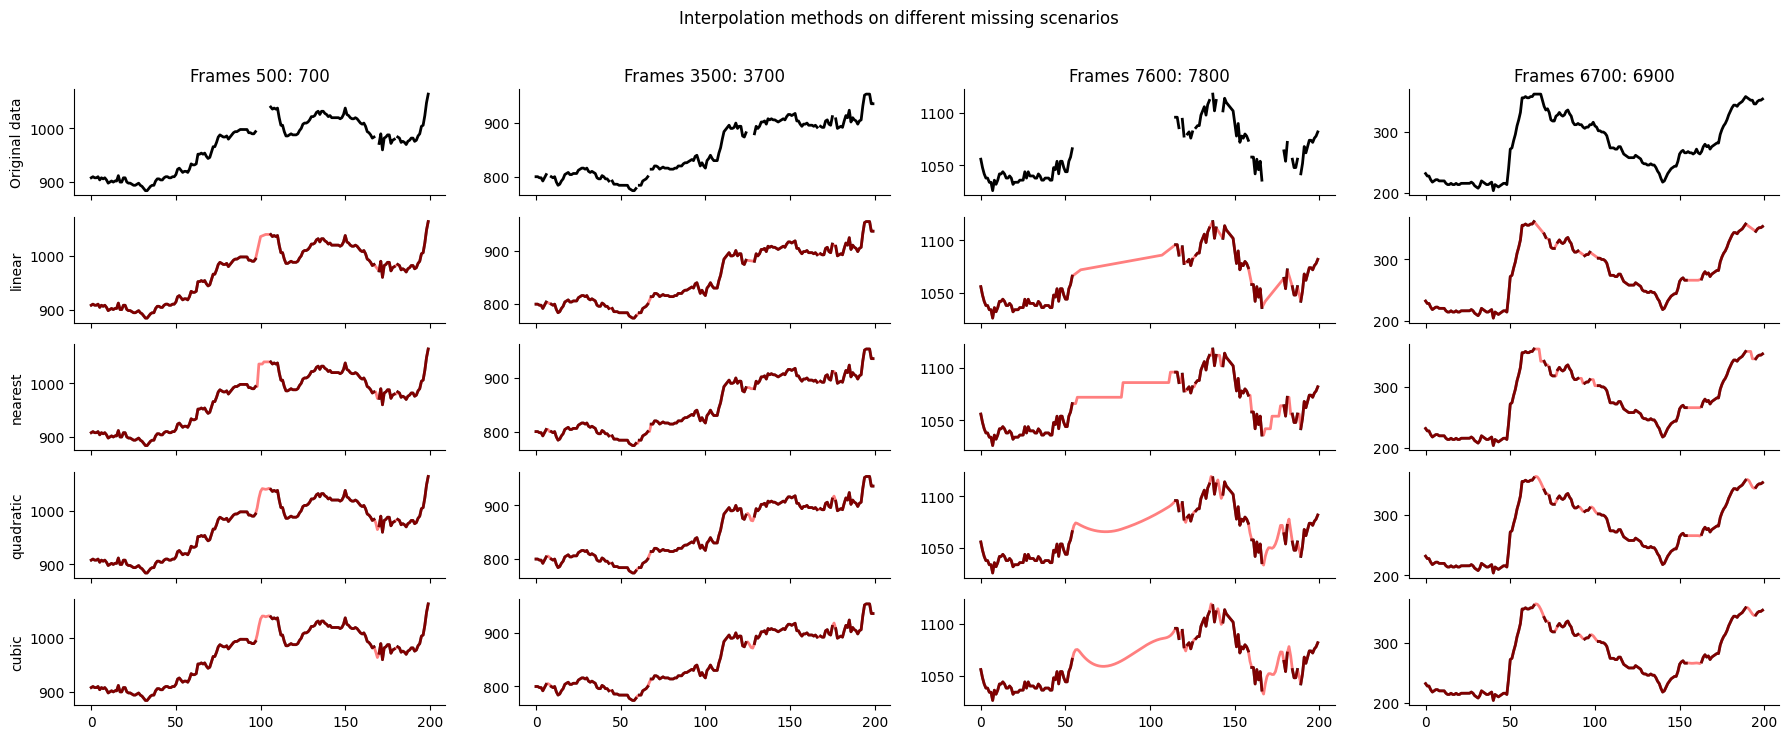

In [104]:
## More succint with scipy.interpoalte.interp1d

avail_methods = ["linear", "nearest", "quadratic", "cubic"]

fig, axs = plt.subplots(1 + len(avail_methods), 4, figsize = (22, 8), sharex = True)

frame_duration = [(500, 700), (3500, 3700), (7600, 7800), (6700, 6900)]
test_nan_indices = np.array([65, 66, 67, 68, 69,
                             72, 77, 91, 92, 93,
                             93, 98, 99, 100, 101,
                             155, 157, 158, 160, 162,
                             190, 191, 192, 193, 194])

# Original
for dur, ax in zip(frame_duration, axs.flatten()[:4]):
    ax.plot(random_joints[dur[0]: dur[1]], lw = 2, c = "k")
    ax.set_title(f"Frames {dur[0]}: {dur[1]}")


for m_idx, method in enumerate(avail_methods):
    for idx, (dur, ax) in enumerate(zip(frame_duration, axs.flatten()[(m_idx + 1) * 4: (m_idx + 2) * 4])):
        y = copy.deepcopy(random_joints[dur[0]: dur[1]])
        if idx == 3:
            nan_indices = test_nan_indices
            y[nan_indices] = np.nan
        else:
            nan_indices = np.argwhere(np.isnan(y)).flatten()
            
        data_indices = np.argwhere(~np.isnan(y)).flatten()
        data_points = y[data_indices]

        cubic_spline = interpolate.interp1d(data_indices, data_points, kind = method)
        y[nan_indices]= cubic_spline(nan_indices)

        if idx == 3:
            y1 = copy.deepcopy(random_joints[dur[0]: dur[1]])
            y1[nan_indices] = np.nan
            ax.plot(y1, c = "k", label = "original", lw = 2)
        else:
            ax.plot(random_joints[dur[0]: dur[1]], c = "k", label = "original", lw = 2)
            
        ax.plot(y, c = "r", label = "interpolated", alpha = .5, lw = 2)
    axs[m_idx + 1, 0].set_ylabel(f"{method}")

axs[0, 0].set_ylabel("Original data")

plt.suptitle("Interpolation methods on different missing scenarios", y = .98)
sns.despine()

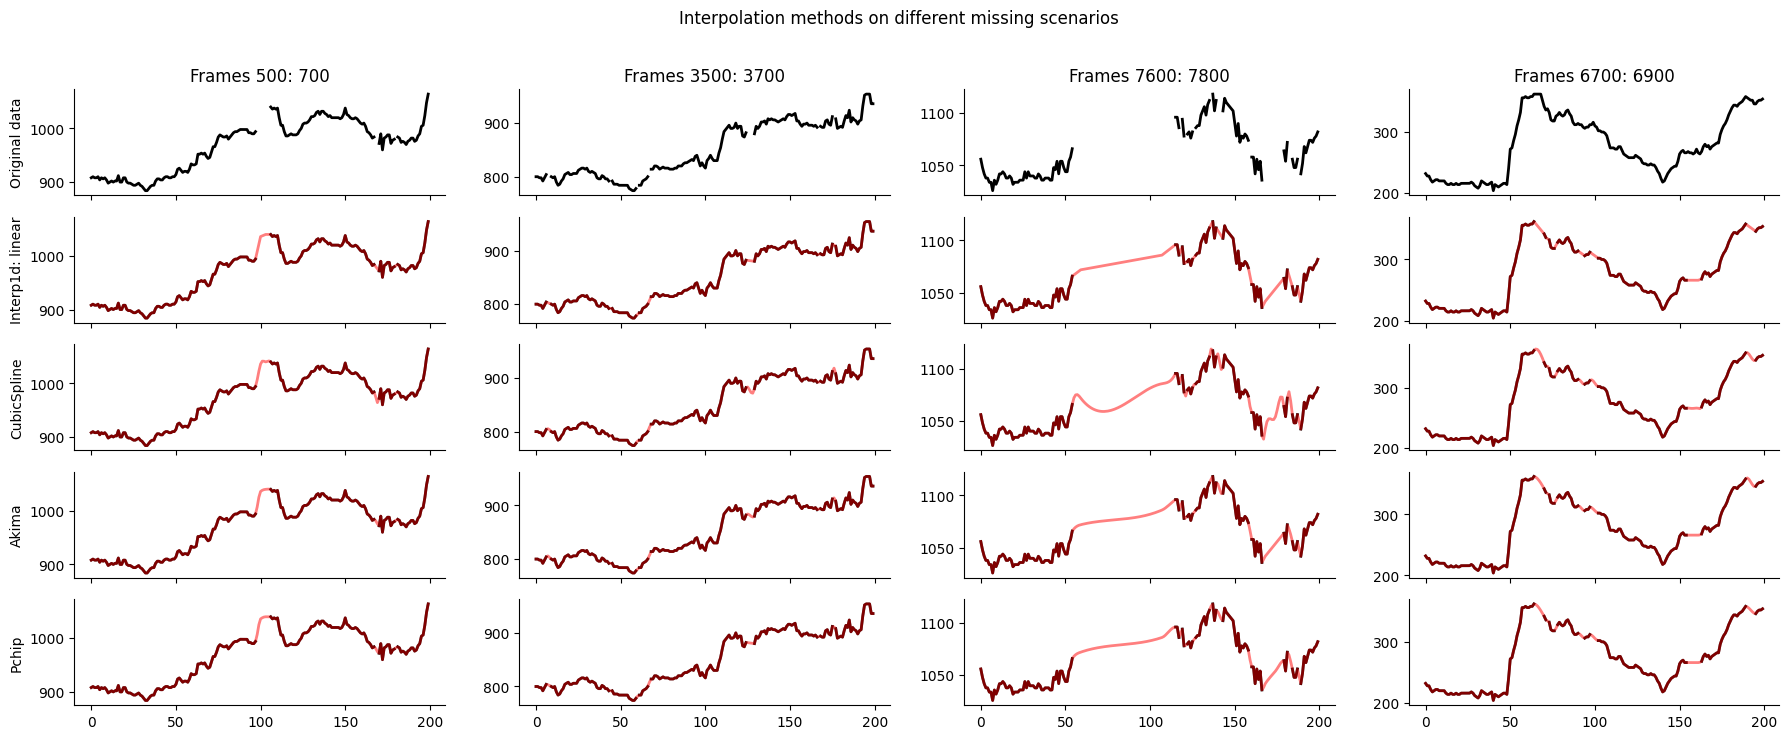

In [105]:
## More succint with scipy.interpoalte.interp1d

avail_methods = [interpolate.interp1d, interpolate.CubicSpline, interpolate.Akima1DInterpolator, interpolate.PchipInterpolator]
method_names = ["Interp1d: linear", "CubicSpline", "Akima", "Pchip"]

fig, axs = plt.subplots(1 + len(avail_methods), 4, figsize = (22, 8), sharex = True)

frame_duration = [(500, 700), (3500, 3700), (7600, 7800), (6700, 6900)]
test_nan_indices = np.array([65, 66, 67, 68, 69,
                             72, 77, 91, 92, 93,
                             93, 98, 99, 100, 101,
                             155, 157, 158, 160, 162,
                             190, 191, 192, 193, 194])

# Original
for dur, ax in zip(frame_duration, axs.flatten()[:4]):
    ax.plot(random_joints[dur[0]: dur[1]], lw = 2, c = "k")
    ax.set_title(f"Frames {dur[0]}: {dur[1]}")


for m_idx, (method, m_name) in enumerate(zip(avail_methods, method_names)):
    for idx, (dur, ax) in enumerate(zip(frame_duration, axs.flatten()[(m_idx + 1) * 4: (m_idx + 2) * 4])):
        y = copy.deepcopy(random_joints[dur[0]: dur[1]])
        if idx == 3:
            nan_indices = test_nan_indices
            y[nan_indices] = np.nan
        else:
            nan_indices = np.argwhere(np.isnan(y)).flatten()
            
        data_indices = np.argwhere(~np.isnan(y)).flatten()
        data_points = y[data_indices]

        cubic_spline = method(data_indices, data_points)
        y[nan_indices]= cubic_spline(nan_indices)

        if idx == 3:
            y1 = copy.deepcopy(random_joints[dur[0]: dur[1]])
            y1[nan_indices] = np.nan
            ax.plot(y1, c = "k", label = "original", lw = 2)
        else:
            ax.plot(random_joints[dur[0]: dur[1]], c = "k", label = "original", lw = 2)
            
        ax.plot(y, c = "r", label = "interpolated", alpha = .5, lw = 2)
    axs[m_idx + 1, 0].set_ylabel(f"{m_name}")

axs[0, 0].set_ylabel("Original data")

plt.suptitle("Interpolation methods on different missing scenarios", y = .98)
sns.despine()